# Week 3 homeworks - Spurious waffles and Haunted DAG

In [1]:
%load_ext lab_black
%load_ext watermark
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

sns.set(context="notebook", font_scale=1.2, rc={"figure.figsize": (12, 5)})
plt.style.use(["seaborn-colorblind", "seaborn-darkgrid"])

RANDOM_SEED = 8927
np.random.seed(286)

# Helper function
def stdz(series: pd.Series):
    """Standardize the given pandas Series"""
    return (series - series.mean()) / series.std()

*All three problems below are based on the same data. The data in foxes.csv are 116 foxes from 30 different urban groups in England. These foxes are like street gangs. Group size varies from 2 to 8 individuals. Each group maintains its own (almost exclusive) urban territory. Some territories are larger than others. The `area` variable encodes this information. Some territories also have more `avgfood` than others. We want to model the `weight` of each fox. For the problems below, assume this DAG:*

![Foxes DAG](img/foxes-dag.png)

1. *Use a model to infer the total causal influence of `area` on `weight`. Would increasing the area available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulations to show that your model’s prior predictions stay within the possible outcome range.*

Because there are no back-door paths from `area` to `weight`, we only need to include `area`. No other variables are needed. Let's first standardized the variables and check our priors choices:

In [2]:
foxes = pd.read_csv("../Data/foxes.csv", sep=";")
foxes["area"] = stdz(foxes.area)
foxes["avgfood"] = stdz(foxes.avgfood)
foxes["groupsize"] = stdz(foxes.groupsize)
foxes["weight"] = stdz(foxes.weight)
foxes.describe().round(2)

,group,avgfood,groupsize,area,weight
count,116.00,116.00,116.00,116.00,116.00
mean,17.21,0.00,-0.00,-0.00,0.00
std,8.00,1.00,1.00,1.00,1.00
min,1.00,-1.92,-1.52,-2.24,-2.20
25%,11.75,-0.46,-0.87,-0.62,-0.68
50%,18.00,-0.08,-0.22,-0.04,-0.09
75%,24.00,0.24,0.43,0.65,0.71
max,30.00,2.31,2.38,2.05,2.55


Text(0, 0.5, 'Mean weight (std)')

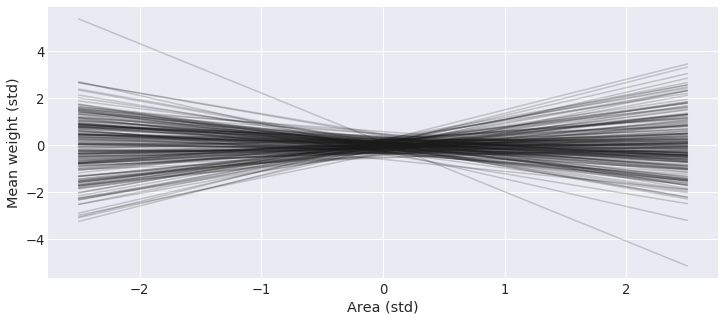

In [3]:
# Prior predictive checks, to see if prior choice makes sense
a_s = pm.Normal.dist(mu=0.0, sd=0.2).random(size=200)
bA_s = pm.Normal.dist(mu=0.0, sd=0.5).random(size=200)

plt.figure(figsize=(12, 5))
for y_s in zip(a_s - 2.5 * bA_s, a_s + 2.5 * bA_s):
    plt.plot([-2.5, 2.5], y_s, color="k", alpha=0.2)
plt.xlabel("Area (std)")
plt.ylabel("Mean weight (std)")

Here is a model using these standardized variables and priors:

In [4]:
with pm.Model() as m_fox:
    a = pm.Normal("a", 0.0, 0.2)
    bA = pm.Normal("bA", 0.0, 0.5)

    mu = a + bA * foxes.area
    sigma = pm.Exponential("sigma", 1.0)

    W = pm.Normal("W", mu, sigma, observed=foxes.weight)

    trace_fox = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

post_fox = pm.trace_to_dataframe(trace_fox)
az.summary(trace_fox, credible_interval=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:09<00:00, 653.76draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.09,-0.15,0.13,0.0,0.0,3443.41,1027.93,3455.51,1682.05,1.0
bA,0.02,0.09,-0.11,0.17,0.0,0.0,2749.24,947.60,2770.97,1437.18,1.0
sigma,1.01,0.07,0.90,1.11,0.0,0.0,2486.80,2390.56,2622.76,1476.02,1.0


Territory size seems to have no total causal influence on weight, at least not in this sample.

2. *Now infer the causal impact of adding food to a territory. Would this make foxes heavier? Which covariates do you need to adjust for to estimate the total causal influence of food?*

To infer the causal influence of `avgfood` on `weight`, we need to close any back-door paths. There are no back-door paths in the DAG. So again, just use a model with a single predictor. If you include `groupsize`, to block the indirect path, then you won’t get the *total* causal influence of food. You’ll just get the *direct* influence. But I asked for the *total* effect of adding food, and that would mean through all forward paths.

In [5]:
with pm.Model() as m_food:
    a = pm.Normal("a", 0.0, 0.2)
    bF = pm.Normal("bF", 0.0, 0.5)

    mu = a + bF * foxes.avgfood
    sigma = pm.Exponential("sigma", 1.0)

    W = pm.Normal("W", mu, sigma, observed=foxes.weight)

    trace_food = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

post_food = pm.trace_to_dataframe(trace_food)
az.summary(trace_food, credible_interval=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bF, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:08<00:00, 730.71draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.09,-0.13,0.14,0.0,0.0,2862.87,1015.79,2904.02,1476.23,1.0
bF,-0.02,0.09,-0.17,0.12,0.0,0.0,4015.25,1027.10,3997.99,1401.76,1.0
sigma,1.01,0.07,0.90,1.11,0.0,0.0,2975.21,2935.89,2991.55,1500.96,1.0


Again, nothing. Adding food does not change weight. This shouldn’t surprise you, if the DAG is correct, because `area` is upstream of `avgfood`.

3. *Now infer the causal impact of group size. Which covariates do you need to adjust for? Looking at the posterior distribution of the resulting model, what do you think explains these data? That is, can you explain the estimates for all three problems? How do they go together?*

The variable `groupsize` does have a back-door path, passing through `avgfood`. So to infer the causal influence of `groupsize`, we need to close that path. This implies a model with both `groupsize` and `avgfood` as predictors.

In [6]:
with pm.Model() as m_group:
    a = pm.Normal("a", 0.0, 0.2)
    bF = pm.Normal("bF", 0.0, 0.5)
    bG = pm.Normal("bG", 0.0, 0.5)

    mu = a + bF * foxes.avgfood + bG * foxes.groupsize
    sigma = pm.Exponential("sigma", 1.0)

    W = pm.Normal("W", mu, sigma, observed=foxes.weight)

    trace_group = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

post_group = pm.trace_to_dataframe(trace_group)
az.summary(trace_group, credible_interval=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bG, bF, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:13<00:00, 438.74draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.08,-0.13,0.12,0.00,0.0,2093.07,966.76,2089.74,1498.85,1.01
bF,0.48,0.18,0.20,0.80,0.01,0.0,1146.88,1139.20,1144.75,1154.05,1.00
bG,-0.57,0.18,-0.88,-0.30,0.01,0.0,1205.35,1181.08,1204.92,1331.47,1.00
sigma,0.96,0.06,0.87,1.07,0.00,0.0,2036.35,2002.90,2090.18,1436.84,1.00


It looks like group size is negatively associated with weight, controlling for food. Similarly, food is positively associated with weight, controlling for group size. So the causal influence of group size is to reduce weight — less food for each fox. And the *direct* causal influence of food is positive, of course. But the *total* causal influence of food is still nothing, since it causes larger groups. 

This is a masking effect, like in the milk energy example. But the causal explanation here is that more foxes move into a territory until the food available to each is no better than the food in a neighboring territory. Every territory ends up equally good/bad on average. This is known in behavioral ecology as an *ideal free distribution*.

In [7]:
%watermark -a AlexAndorra -n -u -v -m -iv

matplotlib 3.0.3
pandas     0.24.2
scipy      1.2.1
pymc3      3.7
seaborn    0.9.0
numpy      1.16.3
arviz      0.4.1
AlexAndorra 
last updated: Wed Sep 11 2019 

CPython 3.7.3
IPython 7.5.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit
